# Multiscalar Segregation Profiles

In [1]:
%load_ext watermark
%watermark -a 'eli knaap' -v -d -u -p segregation,geopandas,libpysal,pandana

Author: eli knaap

Last updated: 2021-05-11

Python implementation: CPython
Python version       : 3.9.2
IPython version      : 7.23.1

segregation: 2.0.0
geopandas  : 0.9.0
libpysal   : 4.3.0
pandana    : 0.6.1



For measuring spatial segregation dynamics, the `segregation` package provides a function for measuring multiscalar segregation profiles, as introduced by [Reardon et al](http://link.springer.com/10.1353/dem.0.0019).
The multiscalar profile is a tool for measuring spatial segregation dynamics--the way that a segregation index changes values as the concept of a neighborhood changes, and what that tells us about macro versus micro patterns of segregation. 

The basic idea is to calculate a segregation statistic, then expand the spatial scope of a neighborhood, recalculate the statistic, and repeat. 
A multiscalar profile can be computed for any generalized spatial segregation index, which in the case of the `segregation` package, means a total of 23 indices, including single and multigroup varieties

In [2]:
from segregation.batch import implicit_multi_indices, implicit_single_indices

In [3]:
len(implicit_single_indices) + len(implicit_multi_indices)

23

## Computing a Single Group Profile

In [4]:
import geopandas as gpd
import matplotlib.pyplot as plt

from libpysal.examples import load_example
from segregation.singlegroup import Dissim, Gini
from segregation.dynamics import compute_multiscalar_profile

In [5]:
sacramento = gpd.read_file(load_example("Sacramento1").get_path("sacramentot2.shp"))
sacramento = sacramento.to_crs(sacramento.estimate_utm_crs())

In [6]:
sac_gini_profile =  compute_multiscalar_profile(sacramento, segregation_index=Gini, 
                                                group_pop_var="BLACK", total_pop_var="TOT_POP", 
                                                distances= range(500,5500,500))

The function returns a pandas Series whose index is the neighborhood distance threshold, and the value is the segregation statistic.

In [7]:
sac_gini_profile

distance
0       0.636176
500     0.636064
1000    0.623789
1500    0.585520
2000    0.536810
2500    0.499351
3000    0.472796
3500    0.452424
4000    0.436661
4500    0.424358
5000    0.412987
Name: Gini, dtype: float64

As such, the profile is easy to plot:

<AxesSubplot:xlabel='distance'>

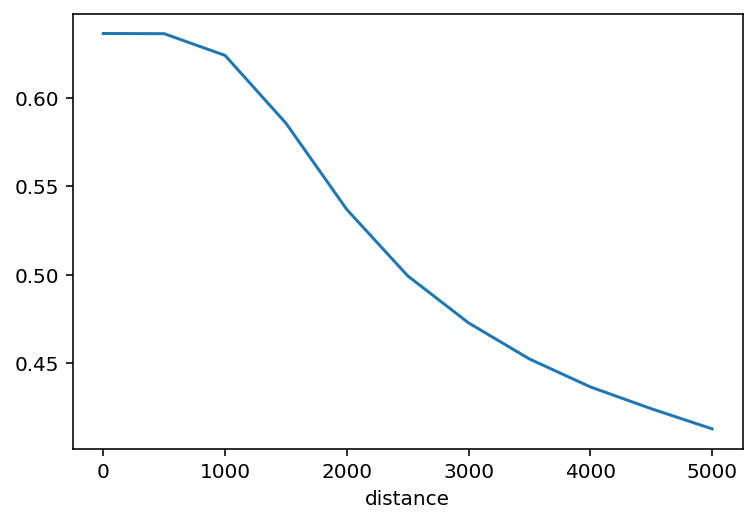

In [8]:
sac_gini_profile.plot()

A good way to compare multiscalar profiles is to plot them in the same figure. For example to compare profiles for gini and dissimilarity indices:

In [9]:
sac_dissim_profile = compute_multiscalar_profile(sacramento, segregation_index=Dissim,
                                                group_pop_var="BLACK", total_pop_var="TOT_POP", 
                                                distances= range(500,5500,500))

In [10]:
from libpysal.weights import DistanceBand

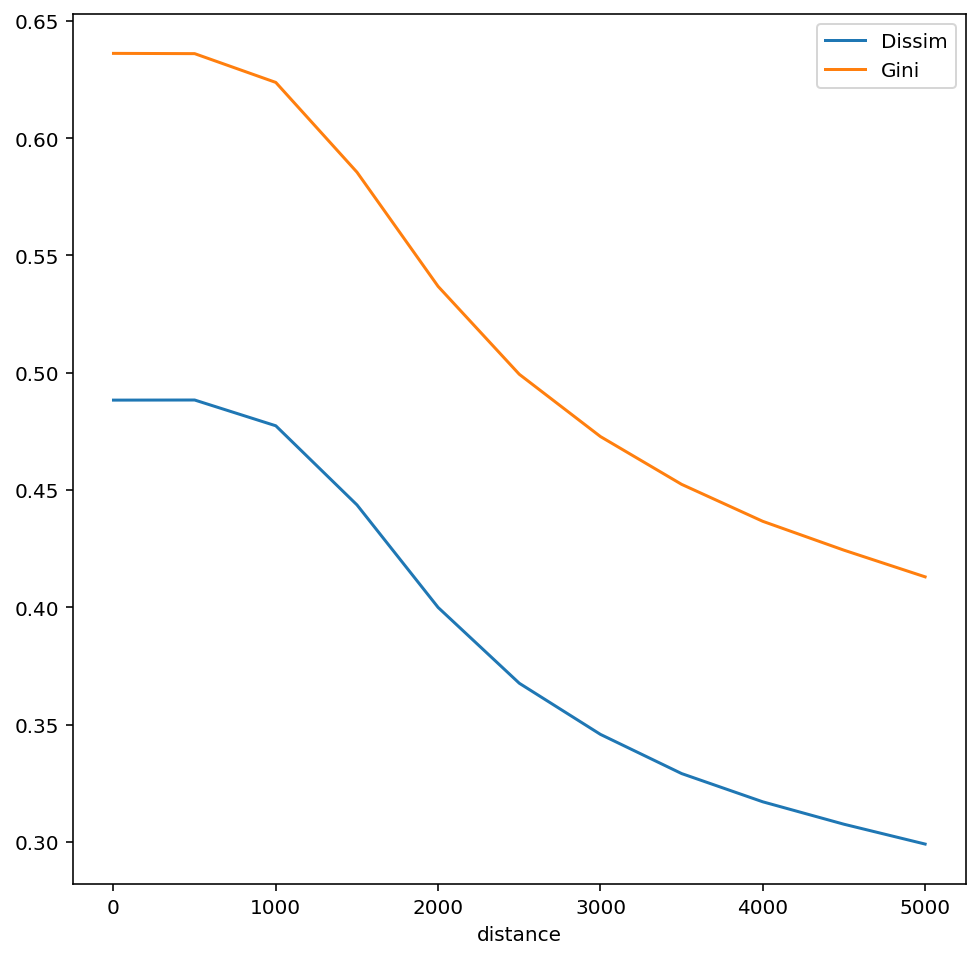

In [11]:
fig, ax = plt.subplots(figsize=(8,8))

sac_dissim_profile.plot(ax=ax)
sac_gini_profile.plot(ax=ax)
ax.legend()

The multiscalar profiles for Gini and Dissimilarity indices are very similar, but have slightly different shapes. 

### Network versus Euclidian Multiscalar Profiles

To calculate a multiscalar profile using travel network distance instead of Euclidian distance, simply pass a `pandana.Network` object to the function

In [12]:
import pandana as pdna

In [13]:
net = pdna.Network.from_hdf5("../40900.h5")

In [14]:
net_dissim_profile = compute_multiscalar_profile(sacramento, segregation_index=Dissim,
                                                group_pop_var="BLACK", total_pop_var="TOT_POP", 
                                                network = net,
                                                distances= range(500,5500,500))

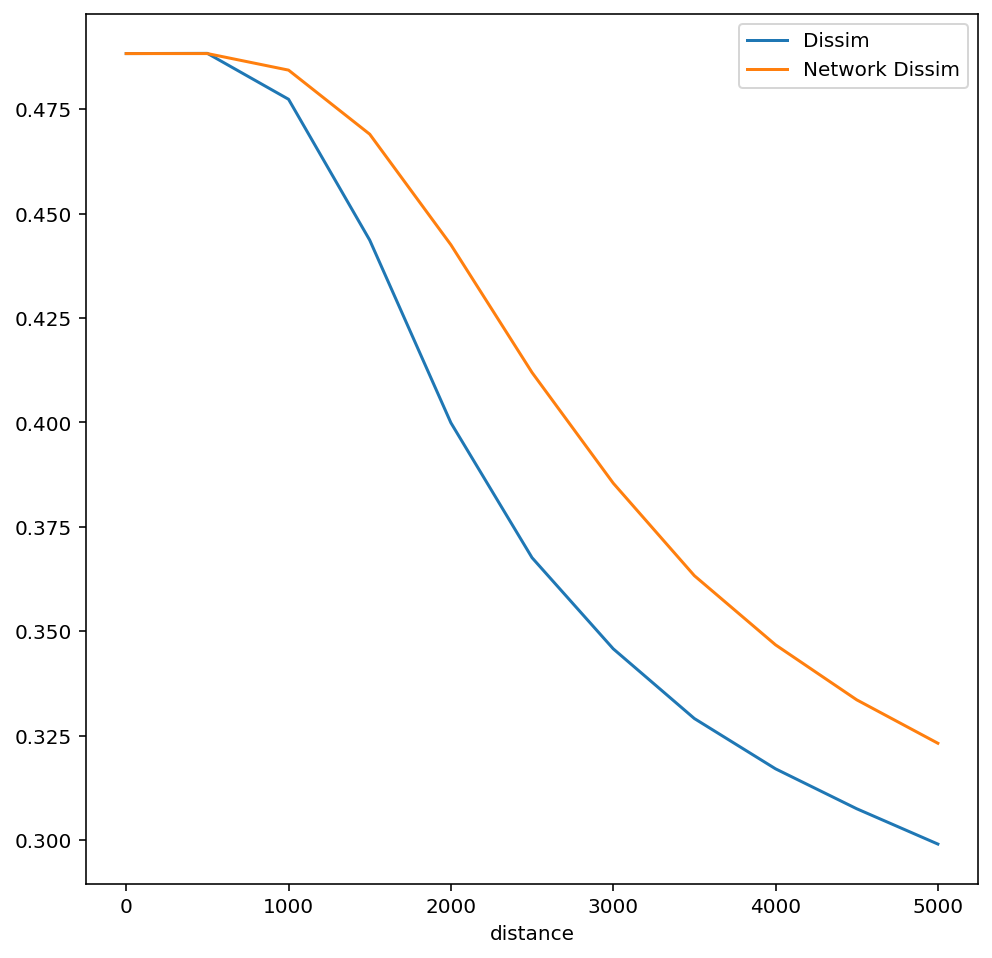

In [15]:
fig, ax = plt.subplots(figsize=(8,8))

sac_dissim_profile.name='Dissim'
net_dissim_profile.name='Network Dissim'
sac_dissim_profile.plot(ax=ax)
net_dissim_profile.plot(ax=ax)
ax.legend()

In this case, comparing the two profiles reveals the role of travel infrastructure on the experience and measurement of segregation; the network-based dissimilarity profile falls slower, indicating that travel networks help insulate segregation at larger distances

## Computing a Multi Group Profile

To calculate a multigroup index (e.g. the multigroup information theory index from the original paper), simply pass a MultiGroupIndex class to the function with multigroup arguments instead of singlegroup

In [16]:
from segregation.multigroup import MultiInfoTheory, MultiGini

In [17]:
multi_info_profile = compute_multiscalar_profile(sacramento, segregation_index=MultiInfoTheory, 
                                          groups=["HISP", 'BLACK', "WHITE"], distances=range(500,5000,500))

multi_gini_profile = compute_multiscalar_profile(sacramento, segregation_index=MultiGini, 
                                          groups=["HISP", 'BLACK', "WHITE"], distances=range(500,5000,500))

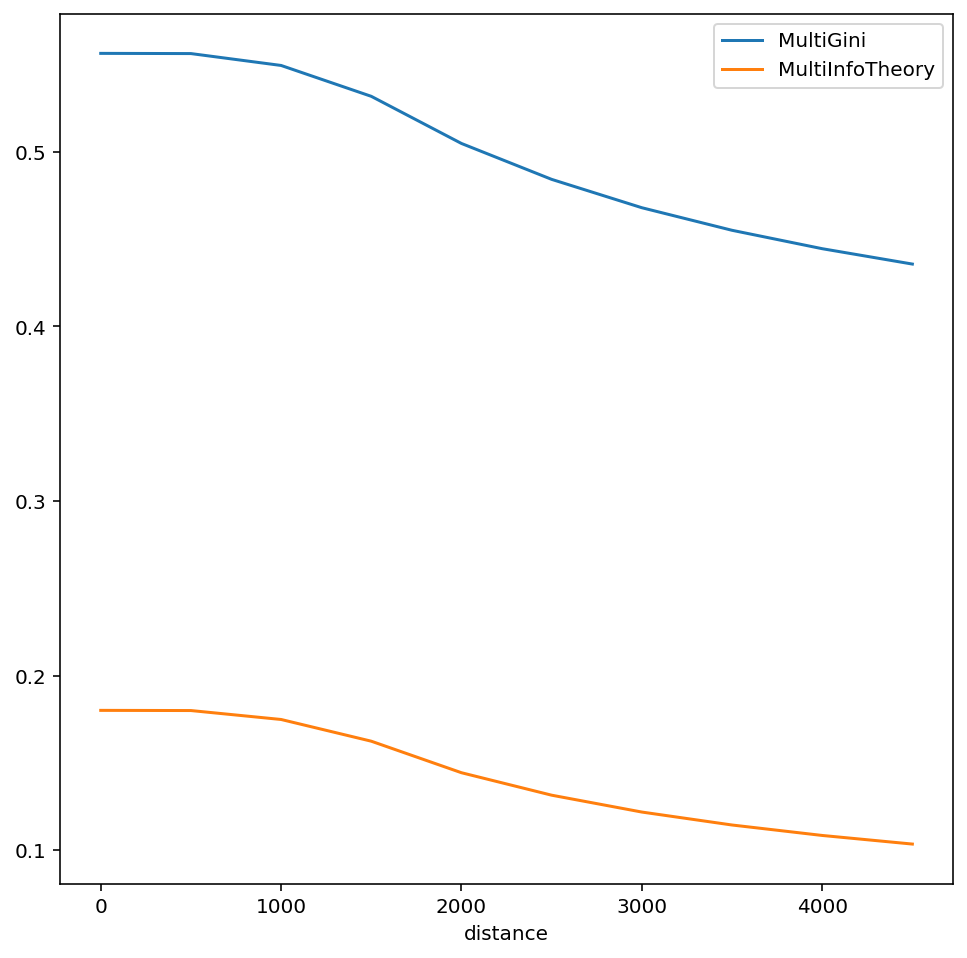

In [18]:
fig, ax = plt.subplots(figsize=(8,8))

multi_gini_profile.plot(ax=ax)
multi_info_profile.plot(ax=ax)
ax.legend()

## Batch-Computing Profiles

In [19]:
from segregation.batch import batch_multiscalar_singlegroup, batch_multiscalar_multigroup

In [20]:
single_profs =  batch_multiscalar_singlegroup(sacramento,group_pop_var="BLACK", total_pop_var="TOT_POP", 
                                                distances= range(500,5500,500))

In [21]:
multi_profs = batch_multiscalar_multigroup(sacramento, distances=range(500,5000,500), groups=["HISP", 'BLACK', "WHITE"])

With several profiles to examine at once, it's helpful to use an interactive plotting library like hvplot

In [22]:
import hvplot.pandas

In [23]:
single_profs.hvplot(width=850, height=450)

:NdOverlay   [Variable]
   :Curve   [distance]   (value)

In [24]:
multi_profs.hvplot(width=850, height=550)

:NdOverlay   [Variable]
   :Curve   [distance]   (value)